# Projected Least-Squares Quantum Process Tomography

*Tutorial by*: Shahnawaz Ahmed
Email: shahnawaz.ahmed95gmail.com  
GitHub: quantshah

*Original implementation*: [Hyperplane Intersection Projection](https://github.com/Hannoskaj/Hyperplane_Intersection_Projection) by Trystan Surawy-Stepney, Jonas Kahn, 
Richard Kueng and Madalin Guta ([arXiv:2107.01060](https://arxiv.org/abs/2107.01060)).

In this notebook, we will demonstrate 4-qubit quantum process tomography (QPT)
using the projected least squares (PLS) method developed in [1]. We will use
the direct QPT method where the input states are Pauli eigenvectors with Pauli
measurements. The process chosen is the quantum fourier transform (QPT) represented
using a single Kraus operator and then converted to the Choi form.

<img src="./images/tomography-qpt.png" alt="qpt" style="width:200px;"/>

Fig 2 from [[1](https://arxiv.org/abs/2107.01060)] showing the idea of projected
least squares process tomography.

The main idea is to first find the least squares estimator for the Choi matrix 
representing the process and then project it to a physical CPTP map. The projection
method in the paper is the [Hyperplane Intersection Projection](https://github.com/Hannoskaj/Hyperplane_Intersection_Projection) which was refactored into this
notebook for a simple demonstration.

We will generate the data from a sampling of the true probabilities for various
input states and measurements on which the quantum channel C is applied.

<img src="./images/tomography-qpt-pauli.png" alt="qpt" style="width:200px;"/>

Fig 4 from [[1](https://arxiv.org/abs/2107.01060)] direct QPT

The channel is the quantum fourier transform for a $k$ qubit circuit.


Note:
----
The code is refactored from the repository [Hyperplane Intersection Projection](https://github.com/Hannoskaj/Hyperplane_Intersection_Projection)
commited by Jonas Kahn for the paper [arXiv:2107.01060](https://arxiv.org/abs/2107.01060).

References
----------

[1] Surawy-Stepney, T., Kahn, J., Kueng, R., & Guta, M. (2021). Projected Least-Squares Quantum Process Tomography. [arXiv:2107.01060](https://arxiv.org/abs/2107.01060).


In [1]:
# imports

import numpy as np

import scipy as sp
from scipy import stats


from qutip import tensor, Qobj, fidelity
from qutip.superop_reps import to_choi, kraus_to_choi


from matplotlib import pyplot as plt
import matplotlib.colors as colors

## The quantum fourier transform gate

In [2]:
def qft_kraus(k):
    """
    Outputs the channel of the quantum Fourier transform for dimension $k$.

    Args:
        k (int): The number of qubits.

    Returns:
        kraus (np.array): The Kraus operator for the QFT unitary.
    """
    mult = np.outer(np.arange(k), np.arange(k))
    kraus = np.array([np.exp(2j * np.pi * mult / k)]) / np.sqrt(k)
    return kraus


k = 4
kraus_true = qft_kraus(2**k)

# The Choi matrix from the Kraus operator

We can construct the Choi matrix from the Kraus operators (using QuTiP) or 
by writing the conversion.

Is CPTP: False


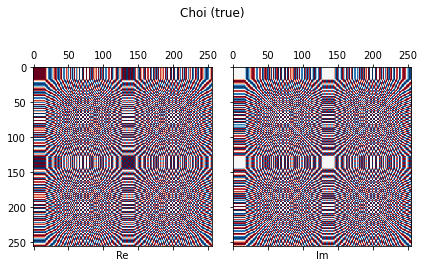

In [3]:
def choi(kraus_ops):
    """Takes the rank-r Kraus reprensentation of a channel
    and returns the Choi matrix of the channel.

    Args:
        kraus_ops (np.ndarray): The (r, d, d)-array representing r Kraus ops

    Returns:
        np.array: A (d^2, d^2) array representing the Choi matrix for the channel
    """
    r, d, d = kraus_ops.shape
    vectorized_kraus = kraus_ops.reshape(r, d ** 2)
    return np.einsum("ij, il -> jl", vectorized_kraus, vectorized_kraus.conj())


def plot_choi(choi, title="", norm=None):
    """Plot the real and imaginary parts of the Choi matrix.

    Args:
        choi (np.array): The Choi matrix for the process
        title (str, optional): The title for the plot.
        norm (colors.TwoSlopeNorm, optional): The normalization for the plot.
    """
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)
    cmap = "RdBu_r"

    if norm is None:
        norm = colors.TwoSlopeNorm(vmin=-np.max(np.abs(choi)), vcenter=0, vmax=np.max(np.abs(choi)))
    im = ax[0].matshow(choi.real, cmap=cmap, norm=norm)
    im2 = ax[1].matshow(choi.imag, cmap=cmap, norm=norm)

    ax[0].set_xlabel("Re")
    ax[1].set_xlabel("Im")

    plt.suptitle(title)
    plt.show()


choi_true = choi(kraus_true)/2**k
choi_qutip = kraus_to_choi([Qobj(kraus_true[0])])/2**k

# Test our implementation of the Choi matrix conversion using QuTiP
np.testing.assert_array_almost_equal(choi_qutip.data.toarray(), choi_true)
print("Is CPTP:", choi_qutip.iscptp)


# Plot the Choi matrix
plot_choi(choi_true, title="Choi (true)")

In [4]:
def prod_pauli_vecs(k, U2=None):
    """Outputs all the k-tensor products of Pauli vectors, as an array where the
    vectors are the lines.

    Note:
    This implementation works till k=8. It needs $12^k$ complex entries.
    U2 allows to add a rotation to the Pauli vectors to avoid very special cases.

    TODO: There could be faster and more general way to do this.

    Args:
        k (int): The number of qubits.
        U2 (np.array, optional): A unitary of dimension 2**k. Defaults to None.

    Returns:
        [type]: [description]
    """
    s2 = np.sqrt(0.5)
    frame_vecs = np.array(
        ([1, 0], [0, 1], [s2, s2], [s2, -s2], [s2, s2 * 1j], [s2, -s2 * 1j])
    )
    if U2 is not None:
        frame_vecs = np.dot(frame_vecs, U2)
    einstein_indices = (
        "ai -> ai",
        "ai, bj -> abij",
        "ai, bj, ck -> abcijk",
        "ai, bj, ck, dl -> abcdijkl",
        "ai, bj, ck, dl, em -> abcdeijklm",
        "ai, bj, ck, dl, em, fn -> abcdefijklmn",
        "ai, bj, ck, dl, em, fn, go -> abcdefgijklmno",
        "ai, bj, ck, dl, em, fn, go, hp -> abcdefghijklmnop",
    )
    return np.einsum(einstein_indices[k - 1], *([frame_vecs] * k)).reshape(6 ** k, -1)


def probas_pauli(k, channel, optimize="optimal"):
    """Yields the probability of each Pauli measurement result for direct
    measurement method.
    
    For a given Pauli input state and measurement basis, sums to
    one. Hence total sum is $18^k$.

    Input: k is the number of qubits,
           channel are the Kraus operators of the channel.
    Output array $(6^k, 6^k)$. First coordinate input state, second 
    coordinate measured output.

    Args:
        k (int): Number of qubits
        channel (np.ndarray): The channel represented by an (r, d, d) dim array
        optimize (str, optional): Einsum optimization strategy.
                                  Defaults to "optimal".

    Returns:
        res (np.ndarray): The probabilities for all combinations of Pauli input
                          states and measurements as a (6**k, 6**k) matrix.
    """
    res = 0
    Pk = prod_pauli_vecs(k)
    # Looping over kraus instead of doing everything in the einsum to
    # avoid excessive memory usage if the rank is high.
    for kraus in channel:
        a = np.einsum("nj, ij, mi -> nm", Pk, kraus, Pk.conj(), optimize="optimal")
        res += a.real ** 2 + a.imag ** 2
    return res


probas = probas_pauli(k, kraus_true)
print(probas.shape)

(1296, 1296)


In [5]:
def M_k(k):
    """Yields least-square estimators components for the input (or the output)
    state.

    Args:
        k (int): The number of qubits.

    Returns:
        mkmat (np.ndarray) : A (6^k, 2^k, 2^k) matrix. The first index
                             represents the index of the input state. The rest
                             of the indices represent the corresponding matrix.
    """
    P1 = prod_pauli_vecs(1)
    # ALERT (original comment by Jonas Kahn)
    #
    # Here I do not understand the position of the conj(). I would have thought
    # it is on the other P1.
    # But it is this way that yields the right result.
    M_1 = np.einsum("nd, ne -> nde", 3 * P1, P1.conj()) - np.eye(2)
    mkmat = np.copy(M_1)

    for i in range(2, k + 1):
        mkmat = np.einsum("nde, mfg -> nmdfeg", mkmat, M_1)
        mkmat = mkmat.reshape(6 ** i, 2 ** i, 2 ** i)
    return mkmat

# Generate the data for QPT

There are 4 qubits and we consider state preparations for tensor products of 
(+X, -X, +Y, -Y, +Z, -Z) on each qubit. The total number of such combinations
are give by 6**k, e.g., (XXYX, -Z-ZYZ, ... ). Therefore in our data, the first
dimension is of size 6**k (1296).
Once these states are prepared, we measure the result again in all combinations
of the tensor products of the basis operators (+X, -X, +Y, -Y, +Z, -Z). Therefore
we have for each state preparation 6**k different measurements. 
The final data is therefore a 6**k, 6**k matrix for all state preparations and
measurements. 

Once we have all the probabilities for different state preparations and
measurements, we can simulate a sampling of the expectation values using a
Poissionian distribution by specifying the number of samples which determines
the number of cycles.

In [6]:
def sampling(probabilities, cycles=1):
    """Sampling of outcomes according to a Poisson distribution with parameter
    $probabilities \times cycles$, and normalization.

    Args:
        probabilities (np.ndarray): An array of probabilities.
        cycles (int, optional): The number of cycles in the experiment.

    Returns:
        samples (np.ndarray): The samples (normalized).
    """
    samples = stats.poisson.rvs(probabilities * cycles)
    samples = samples * (probabilities.sum() / samples.sum())
    return samples


num_samples = 1e8
cycles = num_samples/18**k

data = sampling(probas, cycles)
print("Num shots for each measurement:", cycles)
print("Data shape: ", data.shape)

Num shots for each measurement: 952.5986892242037
Data shape:  (1296, 1296)


# Comparing sampled data to the full probabilities

Let us plot a randomly selected input probe and plot the sampled data against
the true probabilities.

We can also show the error distribution for the data.

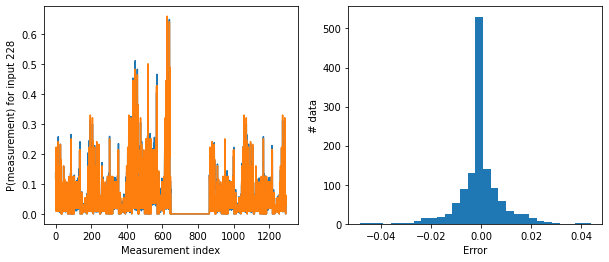

In [7]:
idx = np.random.randint(6**k)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(data[idx], label="Sampled data")
ax[0].plot(probas[idx], label="Probabilities")

ax[1].hist(data[idx] - probas[idx], bins = 30)
ax[0].set_xlabel("Measurement index")
ax[0].set_ylabel("P(measurement) for input {}".format(idx))

ax[1].set_xlabel("Error")
ax[1].set_ylabel("# data".format(idx))
plt.show()

# Finding the least squares estimate directly (Eq (6)) 

In [8]:
Mk = M_k(k)

def choi_ls_pauli(est, data, input_config_slice, output_config_slice, optimize='optimal'):
    """Least squares estimator for direct QPT with inputs and measurements
    determined by Pauli matrices.
    
    We consider all combinations of the Pauli operators
    (+X, -X, +Y, -Y, +Z, -Z) that can act on each qubit. Since there are k qubits
    the number of input and output configurations are 6**k. 

    Args:
        est (array): The current estimate of the Choi matrix.
        data (array [float]): The array of data of shape (m, n) for m inputs and n measurements.
        input_indices (array [int]): The indices specifying the Pauli operators that are used to prepare the input probes
        output_indices (array [int]): The indices specifying the Pauli operators that are measured.
    """
    # Strange order of indices
    est += np.einsum(
        "nm, nde, mfg -> fegd",
        data,
        Mk[input_config_slice],
        Mk[output_config_slice],
        optimize=optimize,
    )
    return est

In [9]:
choi_ls_est = 0.

for i in range(0, 6 ** k, 4 ** k):
    input_config_slice = slice(i, i + 4 ** k)
    # It might also be possible to select random subsets of the data
    # input_config_slice = np.random.randint(0, 6**k, batch_size)
    for o in range(0, 6 ** k, 4 ** k):
        output_config_slice = slice(o, o + 4 ** k)
        # It might also be possible to select random subsets of the measurements
        # output_config_slice = np.random.randint(0, 6**k, batch_size)
        choi_ls_est = choi_ls_pauli(choi_ls_est, data[input_config_slice, output_config_slice], input_config_slice, output_config_slice)


choi_ls_est = choi_ls_est.reshape(4 ** k, 4 ** k)
print("Trace of LS estimate: ", choi_ls_est.trace().real)

choi_ls_est /= choi_ls_est.trace().real

Trace of LS estimate:  104976.00000000032


# Visualize the predicted Choi matrix from the simple least sq. estimate

/Users/shahnawaz/Dropbox/dev/qutip/qutip/qobj.py:519: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


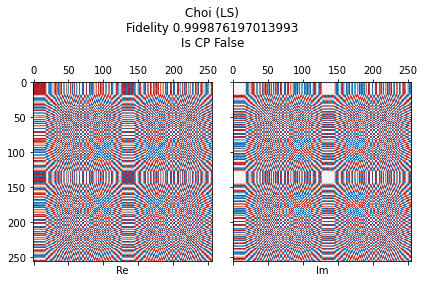

In [10]:
choi_ls_est_qutip = Qobj(choi_ls_est, dims=choi_qutip.dims, superrep='choi')
plot_choi(choi_ls_est, title="Choi (LS)\nFidelity {}\nIs CP {}".format(fidelity(choi_ls_est_qutip, choi_qutip), choi_ls_est_qutip.iscp))

# CPTP projection 

The state is very close to our ideal Choi matrix and is almost TP but to get
a proper CPTP projection, we use the Hyperplane Intersection Projection algorithm

In [11]:
depo_rtol = 1e-16
depo_tol =  1e-16


options_proj={
        "maxiter": 300,
        "HIP_to_alt_switch": "first",
        "missing_w": 3,
        "min_part": 0.1,
        "HIP_steps": 10,
        "alt_steps": 4,
        "alt_to_HIP_switch": "cos",
        "min_cos": 0.99,
        "max_mem_w": 30,
        "genarg_alt": (1, 3, 20),
        "genarg_HIP": (5,),
    }

all_dists=False
first_CP_threshold_least_ev=True,
all_dists=False,
dist_L2=True,
with_evs=False,
keep_key_channels=False,
keep_main_eigenvectors=0,
save_intermediate=True

proj = "HIPswitch"


def ensure_trace(eigvals):
    """
    Ensures that the sum of eigvals is at least one.

    Finds the value l so that $\sum (\lambda_i - l)_+ = 1$
    and set the eigenvalues $\lambda_i$ to $(\lambda_i - l)_+$.

    Args:
        eigvals (array): The set of eigenvalues.

    Returns:
        (array): The modified set of eigenvalues such that the sum is 1.
    """
    trace = eigvals.sum()
    while trace > 1:
        indices_positifs = eigvals.nonzero()
        l = len(indices_positifs[0]) # Number of (still) nonzero eigenvalues
        eigvals[indices_positifs] += (1 - trace) / l  
        eigvals = eigvals.clip(0)
        trace = eigvals.sum() 
    return eigvals


def proj_CP_threshold(rho,  free_trace=True, full_output=False, thres_least_ev=False):
    """
    If thres_least_ev=False and free_trace=False, then projects rho on CP
    trace_one operators.
    
    More generally, changes the eigenvalues without changing the eigenvectors:
    * if free_trace=True and thres_least_ev=False, then projects on CP operators,
    with no trace condition.
    * if thres_least_ev=True, free_trace is ignored. Then we bound from below all 
    eigenvalues by their original value plus the least eigenvalue (which is negative).
    Then all the lower eigenvalues take the lower bound (or zero if it is negative),
    all the higher eigenvalues are unchanged, and there is one eigenvalue in the middle
    that gets a value between its lower bound and its original value, to ensure the
    trace is one.
    """
    eigvals, eigvecs = sp.linalg.eigh(rho) # Assumes hermitian; sorted from lambda_min to lambda_max
    
    least_ev = eigvals[0]
    
    if thres_least_ev:
        threshold = - least_ev # > 0
        evlow = (eigvals - threshold).clip(0)
        toadd = eigvals - evlow
        missing = 1 - evlow.sum()
        if missing < 0: # On this rare event, revert to usual projection
            eigvals = eigvals.clip(0)
            eigvals = ensure_trace(eigvals)
        else:
            inv_cum_toadd =  toadd[::-1].cumsum()[::-1]
            last_more_missing = np.where(inv_cum_toadd >= missing)[0][-1]
            eigvals[:last_more_missing] = evlow[:last_more_missing]
            eigvals[last_more_missing] = eigvals[last_more_missing] + missing - inv_cum_toadd[last_more_missing]    
    else:
        eigvals = eigvals.clip(0)
        if not free_trace:
            eigvals = ensure_trace(eigvals)
        #    
    indices_positifs = eigvals.nonzero()[0]    
    rho_hat_TLS = (eigvecs[:,indices_positifs] * eigvals[indices_positifs]) @ eigvecs[:,indices_positifs].T.conj()
    
    if full_output==2:
        return rho_hat_TLS, least_ev, len(indices_positifs)
    elif full_output:
        return rho_hat_TLS, least_ev
    else:
        return rho_hat_TLS


def proj_TP(rho):
    """
    Projects the Choi matrix rho of a channel on trace-preserving channels.
    """
    d = np.sqrt(len(rho)).astype(int)
    partial_mixed = np.eye(d) / d
    
    # np.trace on the axes corresponding to the system
    correction = np.einsum('de, fg -> dfeg',partial_mixed, (partial_mixed - np.trace(rho.reshape(4 * [d]), axis1=0, axis2=2)))
    return rho + correction.reshape(d**2, d**2)

    
def step2(XW, target):
    """
    Finds a (big) subset of hyperplanes, including the last one, such that
    the projection of the current point on the intersection of the corresponding
    half-spaces is the projection on the intersection of hyperplanes.

    Input: XW is the matrix of the scalar products between the different 
    non-normalized normal directions projected on the subspace TP, written w_i
    in the main functions.
    target is the intercept of the hyperplanes with respect to the starting point,
    on the scale given by w_i.

    Outputs which hyperplanes are kept in subset, and the coefficients on their
    respective w_i in coeffs.
    """
    nb_active = XW.shape[0]
    subset = np.array([nb_active - 1])
    coeffs = [target[-1] / XW[-1, -1]] # Always positive
    for i in range(nb_active - 2, -1, -1):
        test = (XW[i, subset].dot(coeffs) < target[i])
        # The condition to project on the intersection of the hyperplanes is that 
        # all the coefficients are non-negative. This is equivalent to belonging
        # to the normal cone to the facet.
        if test:
            subset = np.r_[i, subset]
            coeffs = sp.linalg.inv(XW[np.ix_(subset, subset)]).dot(target[subset]) 
            # Adding a new hyperplane might generate negative coefficients.
            # We remove the corresponding hyperplanes, except if it is the last 
            # hyperplane, in which case we do not add the hyperplane.
            if coeffs[-1] < 0: 
                subset = subset[1:]
                coeffs = sp.linalg.inv(XW[np.ix_(subset, subset)]).dot(target[subset]) 
            elif not np.all(coeffs >= 0):
                subset = subset[np.where(coeffs >= 0)]
                coeffs = sp.linalg.inv(XW[np.ix_(subset, subset)]).dot(target[subset])
    
    return subset, coeffs


def hyperplane_intersection_projection_switch(
    rho,
    true_Choi,
    maxiter=100,
    free_trace=True,
    least_ev_x_dim2_tol=1e-2,
    all_dists=False,
    dist_L2=True,
    with_evs=False,
    save_intermediate=False,
    HIP_to_alt_switch="first",
    alt_to_HIP_switch="counter",
    min_cos=0.99,
    alt_steps=4,
    missing_w=1,
    min_part=0.3,
    HIP_steps=10,
    max_mem_w=30,
    **kwargs,
):
    """ Switches between alternate projections and HIP, with the following rules:
    * starts in alternate projections.
    * stays in alternate depending on alt_to_HIP_switch:
        ** if 'counter': uses an iterator (alt_steps) of the iteration number to determine the 
        number of consecutive steps before switching. If alt_steps
        is a number, yields this number. If a list cycles on the list.
        ** if 'cos':  switching when two
        successive steps are sufficiently colinear, namely if the cosinus of
        the vectors is at least min_cos.
    * stays in HIP depending on HIP_to_alt_switch:
        ** if 'first': stops HIP when the first active hyperplane
        of the sequence gets discarded. (ex: enter at iteration 7, then leaves when 
        the hyperplane of iteration 7 is not in w_act anymore).
        ** if 'missing', stops when a total of missing_w (default 1) hyperplanes are 
        deemed unnecessary. (ie w_act has lost missing_w member).
        ** if 'part': ends the loop if the length coeff_first * w_first is less than min_part 
        times the step size, ie the length of \sum coeffs_i w_i. This includes the case when
        the first hyperplane is deemed unnecessary, like in 'first'.
        ** if 'counter': uses an iterator (HIP_steps) of the iteration number to determine the 
        number of consecutive steps before switching. Iterator in input iter_choice. If 
        HIP_steps is a number, yields this number. If a list cycles on the list.
    """

    # loops = group.loops
    dim2 = len(rho)
    comp_time = 0
    # x_sq, xiwi = -1, 1 # For the first entry in the loop. Yields the impossible -1.
    sel = "alternate"  # Selector for the step; 'alternate' or 'HIP'.
    if alt_to_HIP_switch == "cos":
        w_norm_ancien = np.zeros(
            (dim2, dim2)
        )  # Not normalized to ensure at least two steps are takenp.
    elif alt_to_HIP_switch == "counter":
        past_al = 0  # number of steps already made in 'alternate' mode.
        alt_step_gen = step_generator(alt_steps)
        current_alt_step = next(alt_step_gen)
    else:
        raise ValueError('Unknown alt_to_HIP_switch. Must be "cos" or "counter".')

    if HIP_to_alt_switch == "counter":
        HIP_step_gen = step_generator(HIP_steps)
        past_HIP = 0
    elif HIP_to_alt_switch == "part":
        pass
    elif HIP_to_alt_switch == "first":
        pass
    elif HIP_to_alt_switch == "missing":
        missed = 0
    else:
        raise ValueError(
            'Unknown HIP_to_alt_switch. Must be "first", "missing", "part" or "counter".'
        )

    dims = (dim2, dim2)

    active = np.array([])
    nb_actives = 0
    XW = np.zeros((0, 0))
    w_act = np.zeros([0, dim2, dim2])
    target = np.array([])
    coeffs = np.array([])

    # rho is on CP, we first project on TP. Outside the loop because we also end on TP.
    rho = proj_TP(rho)

    if save_intermediate:
        rhoTP = [np.expand_dims(rho, 0)]

    least_ev_list = []

    for m in range(maxiter):
        rho_after_CP, least_ev = proj_CP_threshold(rho, free_trace, full_output=True)

        if save_intermediate:
            rhoTP.append(np.expand_dims(rho, 0))
        least_ev_list.append(least_ev)

        # Breaks here because the (- least_ev) might increase on the next rho
        if (sel == "alternate") or (m >= (maxiter - 2)):  # Ensures last ones are AP.
            print("Alternate projections mode")
            # On TP and intersection with hyperplane
            if alt_to_HIP_switch == "cos":
                w_new = proj_TP(rho_after_CP) - rho
                norm_w = sp.linalg.norm(w_new)
                change = np.vdot(w_new / norm_w, w_norm_ancien).real > min_cos
                w_norm_ancien = w_new / norm_w

                # If change with alt_steps, the current projection is transformed into
                # the first HIP step.
                if change:
                    active = np.array([m])
                    nb_actives = 1
                    XW = np.array([[norm_w ** 2]])
                    w_act = np.array([w_new])
                    coeffs = np.array([sp.linalg.norm(rho - rho_after_CP) ** 2 / norm_w ** 2])
                    target = np.array([0.0])
                    rho += coeffs[0] * w_new
                else:
                    rho += w_new

            elif alt_to_HIP_switch == "counter":
                rho = proj_TP(rho_after_CP)
                past_al += 1
                change = past_al >= current_alt_step

                if change:
                    active = np.array([])
                    nb_actives = 0
                    XW = np.zeros((0, 0))
                    w_act = np.zeros([0, dim2, dim2])
                    target = np.array([])
                    coeffs = np.array([])

            if change:
                if HIP_to_alt_switch == "missing":
                    missed = 0
                elif HIP_to_alt_switch == "counter":
                    past_HIP = 0
                    current_HIP_step = next(HIP_step_gen)
                sel = "HIP"

        elif sel == "HIP":  # No other possibility
            print(f"HIP mode. Active hyperplanes: {1 + nb_actives}")

            sq_norm_x_i = sp.linalg.norm(rho - rho_after_CP) ** 2
            w_i = proj_TP(rho_after_CP) - rho
            xiwi = sp.linalg.norm(w_i) ** 2

            XW = np.column_stack([XW, np.zeros(nb_actives)])
            XW = np.row_stack([XW, np.zeros(nb_actives + 1)])
            new_xw = np.einsum(
                "ij, kij -> k", w_i.conj(), w_act
            ).real  # Notice that the scalar product are all real
            # since the matrices are self-adjoint.
            XW[-1, :-1] = new_xw
            XW[:-1, -1] = new_xw
            XW[-1, -1] = xiwi
            target = np.r_[target, sq_norm_x_i]

            active = np.concatenate((active, [m]))
            w_act = np.concatenate([w_act, [w_i]])

            subset, coeffs = step2(XW, target)

            if HIP_to_alt_switch == "missing":
                missed += len(active) - len(
                    subset
                )  # Don't move this after the update to active !!!

            XW = XW[np.ix_(subset, subset)]
            active = active[subset]
            nb_actives = len(active)
            w_act = w_act[subset]
            target = np.zeros((nb_actives,))
            rho += np.einsum("k, kij -> ij", coeffs, w_act)

            if HIP_to_alt_switch in ["first", "part"]:
                if (
                    subset[0] != 0
                ) or nb_actives > max_mem_w:  # max_mem_w limits memory usage
                    change = True
                elif HIP_to_alt_switch == "part":
                    step_size = np.sqrt(np.einsum("i, ij, j", coeffs, XW, coeffs))
                    w_first_contrib = coeffs[0] * np.sqrt(XW[0, 0])
                    change = min_part * step_size >= w_first_contrib
                else:
                    change = False
            elif HIP_to_alt_switch in ["counter", "missing"]:

                # Limits memory usage
                if nb_actives > max_mem_w:
                    nb_actives -= 1
                    active = active[1:]
                    w_act = w_act[1:]
                    target = target[1:]
                    XW = XW[1:, 1:]
                    if HIP_to_alt_switch == "missing":
                        missed += 1
                # End max_mem_w case

                if HIP_to_alt_switch == "missing":
                    change = missed >= missing_w
                elif HIP_to_alt_switch == "counter":
                    past_HIP += 1
                    change = past_HIP >= current_HIP_step

            if change:
                if alt_to_HIP_switch == "cos":
                    w_norm_ancien = np.zeros(
                        (dim2, dim2)
                    )  # Ensures two alternate steps. Also possible to
                    # use w_norm_ancien = w_i / sqrt(xiwi)
                elif alt_to_HIP_switch == "counter":
                    past_al = 0
                    current_alt_step = next(alt_step_gen)
                sel = "alternate"

        else:
            raise ValueError('How did I get there? Typo on "HIP" or "alternate"?')

    return rhoTP, least_ev_list, m



def final_CPTP_by_mixing(rho, full_output=False):
    """
    Assumed to be in TP.
    """
    d = len(rho)
    abs_least_ev = - sp.linalg.eigvalsh(rho, subset_by_index=[0,0])[0]
    if full_output:
        return (rho + abs_least_ev * np.eye(d)) / (1 + d * abs_least_ev), - abs_least_ev
    else:
        return (rho + abs_least_ev * np.eye(d)) / (1 + d * abs_least_ev)

In [12]:
first_CP_threshold_least_ev=True,

rho = choi_ls_est
# CP estimator: first projection on CP matrices
rhoCP, LS_least_ev = proj_CP_threshold(rho, full_output=True, thres_least_ev=first_CP_threshold_least_ev)
ls_rel = -LS_least_ev * depo_rtol
least_ev_x_dim2_tol = np.maximum(ls_rel, depo_tol)

In [13]:
rho_list, least_ev_pls, iterations = hyperplane_intersection_projection_switch(
            rhoCP,
            choi_true,
            **options_proj,
            least_ev_x_dim2_tol=least_ev_x_dim2_tol,
            all_dists=all_dists,
            with_evs=with_evs,
            dist_L2=dist_L2,
            save_intermediate=save_intermediate,
        )

choi_pred = final_CPTP_by_mixing(rho_list[-1][0])

Alternate projections mode
Alternate projections mode
Alternate projections mode
HIP mode. Active hyperplanes: 2
HIP mode. Active hyperplanes: 3
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
HIP mode. Active hyperplanes: 2
HIP mode. Active hyperplanes: 3
HIP mode. Active hyperplanes: 3
HIP mode. Active hyperplanes: 4
HIP mode. Active hyperplanes: 5
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
Alternate projections mode
HIP mode. Active hyperplanes: 2
HIP mode. Active hyperplanes: 3
HIP mode. Active hyperplanes: 3
HIP mode. Active hyperplanes: 4
HIP mode. Active hyperplanes: 5
Alternate projections mode
Alternate projections mode
Alternate projections 

Alternate projections mode


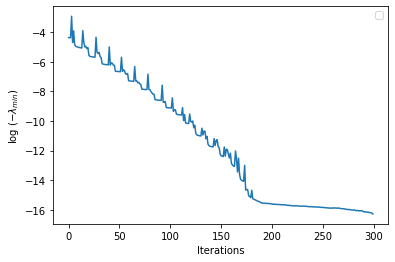

In [14]:
plt.plot(np.log10(-np.array(least_ev_pls)))
plt.legend()
plt.xlabel("Iterations")
plt.ylabel(r"log ($-\lambda_{min}$)")
plt.show()

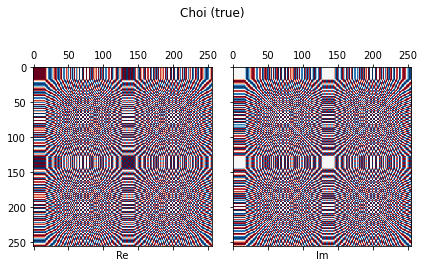

/Users/shahnawaz/Dropbox/dev/qutip/qutip/qobj.py:519: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


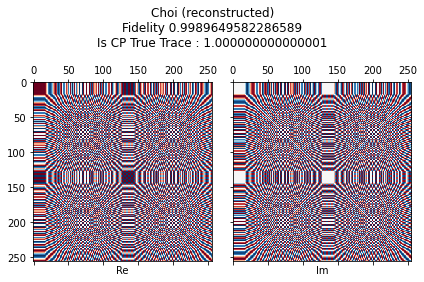

In [15]:
choi_pred_qutip = Qobj(choi_pred, dims=choi_qutip.dims, superrep="choi")

plot_choi(choi_true, title="Choi (true)")
plt.show()

plot_choi(choi_pred, title="Choi (reconstructed)\nFidelity {}\nIs CP {} Trace : {}".format(fidelity(choi_qutip.unit(), choi_pred_qutip), choi_pred_qutip.iscp, choi_pred_qutip.tr()))
plt.show()
